# Prüfungsleitung Maschnielles Lernen: Gruppe 8

bearbeitet von folgenden Matrikelnummern: 2150648, 8503403 <br>
Isolet download: https://datahub.io/machine-learning/isolet

In der vorliegenden Prüfungsleistung wurde die Aufgabe gestellt, Buchstaben anhand von Audioaufnahmen zu erkennen. Als Datenset diente eine bereits vorgefertigte Matrix mit 7797 Samples, welches 617 Merkmalen aus den Audioaufnahmen extrahiert hat. Die 617 Merkmale sind Gleitkommazahlen im Wertebereich von -1 bis 1. Das Notebook beinhaltet beide gestellten Aufgaben, sowie den Code und die dazugehörige Dokumentation in Markdown-Boxen. In der ersten Aufgabe handelt es sich um die Erstellung eines Modells mittels überwachter Lernverfahren. Bei der zweiten Aufgabe mittels einem Deep Learning-Modell. <br>
Die zu verwendeten Bibliothek sind folgende:
* vorgegebene Bibliotheken: sklearn und numpy
* weitere Bibliotheken: pandas, skfeature-chappers und matplotlib

Der Code wurde mit Python v3.10.8 getestet

### Aufgabe 1

Lösung durch Merkmalsbasiertes Machine Learning.

#### 1.1) Import und Splitting des Datensatzes

##### Import(s)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from skfeature.function.similarity_based import fisher_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

Das zu importierende Datenset soll den Namen "raw_isolet.csv" tragen und im gleichen Pfad, wie das Notebook sein. Zum Zeitpunkt des Herunterladen der Isolet-Datei war die Abgrenzung der Werte durch das Komma-Symbol erfolgt. Sollte sich das geändert haben, muss der Parameter delimeter angepasst werden.

In [2]:
# import
df_raw_isolet = pd.read_csv("./raw_isolet.csv", delimiter=",")

##### Datenbereinigung

Um Unklarheiten zu umgehen, wurde die Spalte 'Class' in 'Letter' umbenannt. <br>
Außerdem wurden die String-typischen Anführungszeichen entfernt. <br>
Zuletzt wird das Datenset in die Merkmale "df_features" und die Buchstaben "df_letters" gesplittet.

In [3]:
# changing column name 'class' to 'letter' 'cause class is a reserved keyword in python 
df_raw_isolet.rename(columns={'class': 'letter'}, inplace=True)
# removing char ' from letter
df_raw_isolet['letter'] = df_raw_isolet['letter'].replace({'\'': ''}, regex=True)

df_features = df_raw_isolet.iloc[:, :617]
df_letters = df_raw_isolet.iloc[:, 617]

##### Einfache Datenbetrachtung

Um etwas mehr Verständnis und Gefühl für das Datenset zu bekommen, wird eine einfache Datenbetrachtung ausgeführt, wie beispielsweise die Anzahl aller Samples je Buchstabe. Dies wird anschließend benötigt um eine gleichmäßige Verteilung von Trainingsdaten zu gewährleisten.

In [4]:
print("Einträge in isolet.csv", len(df_raw_isolet))
print("Gruppierte Einträge:", df_raw_isolet.groupby(['letter']).size())

Einträge in isolet.csv 7797
Gruppierte Einträge: letter
1     300
10    300
11    300
12    300
13    299
14    300
15    300
16    300
17    300
18    300
19    300
2     300
20    300
21    300
22    300
23    300
24    300
25    300
26    300
3     300
4     300
5     300
6     298
7     300
8     300
9     300
dtype: int64


Bei der Betrachtung der Anzahl ist auffällig, dass in der Regel pro Buchstabe 300 Einträge aufgezeichnet wurden. Da aber len(df) nur 7797 Einträge beinhaltet, gibt es einige Ausnahmen. <br>
Ausnahmen: Buchstabe 13 mit 299 Einträgen und Buchstabe 6 mit 298 Einträgen <br><br>
Insgesamt bietet die sehr ausgewogene Verteilung der jeweiligen Buchstaben eine sehr gute Basis zum Training des Modells. So wird für jeden Buchstaben ein Testsatz von je 75 Einträge bestimmt. Formel: ⎡Anzahl Einträge pro Buchstabe * 0,25⎤

##### Data Splitting

Der Datensatz wird nun mit dem gewünschten Verhältnis (test_size) eingeteilt. Damit die Anzahl an Klassen (Buchstaben) gleichmäßig verteilt ist, werden die Datensätze nicht vermischt (shuffle=False). 

In [5]:
features_train, features_test, letters_train, letters_test = train_test_split(df_features, df_letters, test_size=.25, shuffle=False)

#### 1.2) Merkmalsreduktion

Die Merkmalsreduktion trägt dazu bei das Modell zu vereinfachen und das Training zu beschleunigen. In den meisten Fällen sind viele extrahierte Merkmale miteinander korrelierend. Diese können mittels verschiedenen Algorithmen ermittelt und kompensiert werden. Dadurch beugt man auch das Risiko des Overfittings vor. Zur Merkmalsreduktionen gibt es zwei unterschiedliche Vorgehensweisen: Transformation oder Selektion.

##### durch Merkmalstransformation - Principal Component Analysis

Merkmalstransformation durch Principal Component Analysis ist einer der gängigsten Algorithmen für maschinelles Lernen. Mit ihr lassen sich die Dimensionen durch das Erstellen einer Kovarianzmatrix und das berechnen der Eigenvektoren. Die besten werden beibehalten und die weniger ausschlaggebenden reduziert. In dem unten stehenden Codeblock hat man durch den Parameter 'n_components' die Dimension auf 100 Merkmale reduziert. Die Reduzierung auf 100 ist die maximale Anzahl an Dimensionen die von der genutzten k-Means Bibliothek zulässt.

In [6]:
pca = PCA(n_components=100)
pca.fit(features_train)
features_train_pca = pca.transform(features_train)

##### durch Merkmalsselektion - Fisher Score

Der Fisher Score ist ein Algorithmus der Merkmalsselektion. Der Fisher Score wird berechnet indem die Varianz zwischen den Klassen durch die Varianz innerhalb jeder Klasse geteilt wird. Die Merkmale mit dem höchsten Wert werden als am relevantesten betrachtet. Durch die Variable 'num_features' wird angewiesen die 100 besten Merkmale zu extrahieren.

In [7]:
features_train = features_train.to_numpy()
letters_train = letters_train.to_numpy()

features_test = features_test.to_numpy()
letters_test = letters_test.to_numpy()

rank_idx = fisher_score.fisher_score(features_train, letters_train, mode='rank')

num_features = 100
selected_features_train = features_train[:, rank_idx[:num_features]]
selected_features_test = features_test[:, rank_idx[:num_features]]

#### 1.3) Lösung des Klassifikatorproblems

Das es sich beim Aufgabentyp um das identifizieren von Buchstaben handelt dienst das Modell, anhand bestimmter Merkmalen diese zu klassifizieren. Die Algorithmen sind in der Aufgabenstellung festgelegt:  Random Forst und k-Means Clustering. <br>
Die zwei Klassifikatoren werden jeweils mit den oben definierten Merkmalsreduktionsverfahren vorgestellt.

##### Random Forest Classifier - Principal Component Analysis

Der Random Forest Classifier ist ein Klassifikator, welches die Entscheidung mittels einer Anzahl von Entscheidungsbäumen trifft. Dabei werden anfangs die Bäume durch zufällig ausgewählte Datensätze erstellt und im laufe des Trainings angepasst.

In [8]:
# Create a Gaussian Classifier
rfc_pca = RandomForestClassifier()
rfc_pca.fit(features_train_pca, letters_train)

letters_pred_rfc_pca = rfc_pca.predict(pca.transform(features_test))

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(letters_test, letters_pred_rfc_pca))

Accuracy: 0.9102564102564102


In unseren Durchläufen konnte eine Genauigkeit zwischen 0.89 und 0.92 vorhergesagt werden. Dies ist möglicherweise darauf zurückzuführen, dass durch den PCA eine gute Merkalsreduktion durchgeführt wurde und eine hohe Anzahl an Samples zum trainieren besteht. Beim RFC spielt durch zu zufällige Auswahl auch ein wenig Glück in das Trainieren des Modells. Dieses Glück fällt je mehr Datensätze vorhanden sind.

##### Random Forest Classifier - Fisher Score

In [9]:
#Create a Gaussian Classifier
rfc_fs = RandomForestClassifier()
rfc_fs.fit(selected_features_train, letters_train)

y_pred_rfc_fs = rfc_fs.predict(features_test[:, rank_idx[:num_features]])

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(letters_test, y_pred_rfc_fs))

Accuracy: 0.8656410256410256


##### optionale graphische Darstellung vom Random Forest Classifier

Ein Entscheidungsbaum kann auch graphisch dargestellt werden. Sklearn bietet hierbei die Funktion export_graphviz an. Mithilfe von Graphviz kann die entstanden DOT-Datei in eine SVG-Datei konvertiert werden und angezeigt werden. Da dafür eine [zweite Applikation benötigt](https://graphviz.org/) wird wurde als ein optionales Feature eingefügt. 

In [10]:
# PCA
estimator = rfc_pca.estimators_[5] # Extract single tree
export_graphviz(estimator, out_file='rfc_pca.dot', 
                class_names = list(dict.fromkeys(df_letters.values)),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Fisher Score
estimator = rfc_fs.estimators_[5] # Extract single tree
export_graphviz(estimator, out_file='rfc_fisher.dot', 
                class_names = list(dict.fromkeys(df_letters.values)),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# shell command to convert the dot file to svg: $ dot -Tsvg rfc_xyz.dot -o rfc_xyz.svg

##### k-Means Clustering - Principal Component Analysis

k-Means ist ein ist ein unüberwachtes Lernverfahren, welches selbstständig versucht die Datenpunkte anhand von Clustern zu klassifizieren. Für das Training wird eine gewisse Anzahl an Zentroiden bestimmt wird (Parameter 'n_clusters') und zufällig im Raum verteilt werden (Der Zufall kann durch den Parameter 'random_state' beeinflusst werden). Im Laufe des Training werden die einzelnen Datenpunkte hinzugefügt, einem Zentroiden zugeordnet und dieser dann schließend angepasst. Beim Nutzen des Modells werden die einzelnen Datenpunkte mit den Zentroiden verglichen und so den Datenpunkt klassifiziert. 

In [11]:
kmeans_pca = KMeans(n_clusters=26, random_state=42)
kmeans_pca_label = kmeans_pca.fit_predict(features_train_pca)
kmeans_pca.fit(features_train_pca)
letters_pred_kmeans_pca = kmeans_pca.predict(pca.transform(features_test))

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(letters_test.astype(np.int0), letters_pred_kmeans_pca))

Accuracy: 0.024102564102564103


Ein wesentlicher Nachteil eines unüberwachtes Lernverfahren, ist dass es selbstständig versucht die Daten zu klassifizieren eigene Klassifikationsgrenzen zu erkennen ohne die eigentliche Klassifikation zu kennen. Bei diesem Verfahren kommt es wirklich auf die Reihenfolge des Trainingsablauf an und dass die Zentroiden schon im Vorfeld einigermaßen richtig platziert wurden. Ist dies nicht der Fall und arbeitet mit einem Datensatz, welches 100 Dimensionen besitzt wird es für diesen Algorithmus sehr schwer auch die echten Klassensamples zu bestimmen. <br> <br>

Um das Problem visueller Darzustellen wurde ein sehr vereinfachtes Diagramm erstellt, welches nur die ersten beiden Dimensionen des Datensatz nutzt.

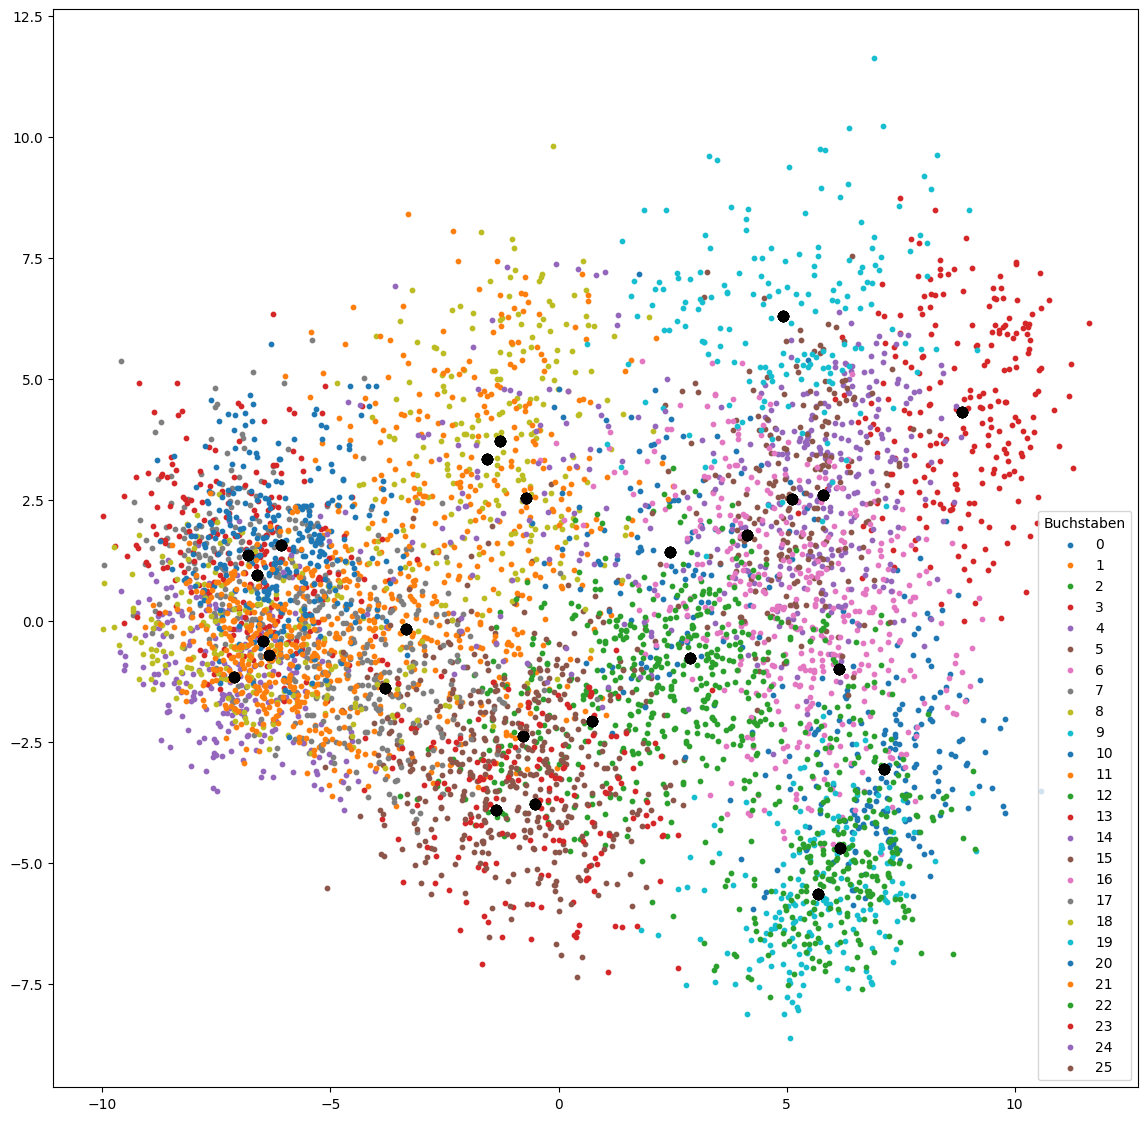

In [12]:
# set graph size
figure(figsize=(14,14))

# labeling
u_labels = np.unique(kmeans_pca_label)
centroids = kmeans_pca.cluster_centers_


#plotting the results:
for i in u_labels:
    plt.scatter(features_train_pca[kmeans_pca_label == i , 0], features_train_pca[kmeans_pca_label == i , 1], label = i, s=10)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = 'k')
plt.legend(title="Buchstaben")
plt.show()

In der Visualisierung ist erkennbar, das viele Zentroiden eng bei einander liegen und die keine guten Grenzen zwischen den Buchstaben erkennbar ist. Ein weiterer wichtiger Aspekt, ist dass die Buchstaben, die von Algorithmus bestimmte Klassifikation ist und nicht die eigentliche. Erkennbar ist es, dass viele Datenpunkte überlappen. Dieses Diagramm kann aber nicht als ein repräsentes Argument für das Problem genommen werden, da 98 weitere Dimensionen vernachlässigt wurden - sollte aber die Nachteile des Algorithmus aufzeigen.  


##### k-Means Clustering - Fisher Score

In [13]:
kmeans_fs = KMeans(n_clusters=26, random_state=42)
kmeans_fs.fit(selected_features_train)
letters_pred_kmeans_fs = kmeans_pca.predict(features_test[:, rank_idx[:num_features]])

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(letters_test.astype(np.int0), letters_pred_kmeans_fs))

Accuracy: 0.041025641025641026


Auch mit dem Fisher Score verbessert sich die Genauigkeit nicht qualitativ genug. Es könnte wiederum auch am gleichen Problem liegen.

#### 1.4) Evaluierung

Im bisherigen Verlauf konnte festgestellt werden, dass die Genauigkeit der verschiedenen Algorithmen je nach Durchlauf variiert. Bereits oben konnte aufgezeigt werden, dass viele der Algorithmen mit Zufällen arbeiten. Beispielsweise die zufällige Auswahl durch Bootstrapping beim Random Forst Classifier oder das erstmalige platzieren der Zentroiden. Damit dennoch ein verlässliche Aussage der Genauigkeit eines Modells vorhergesagt werden ist einer der Methode auf das Setzen der höheren Anzahl an Trainingsiterationen (Splits). Zum Erstellen der Trainingsiterationen wir der Testdatensatz in Folds (Anzahl 1 durch x gewünschten Iterationen) geteilt. So können multiple Trainings stattfinden, welches als Validierung den für ihn bestimmten Testfold verwenden.  <br><br>

In der Aufgabenstellung war es deshalb gefordert eine dreifach gefaltete Kreuzvalidierung anzuwenden. <br>
Bei der dreifach gefaltete Kreuzvalidierung wird das Trainingsset in drei Iterationen aufgeteilt zu je mit 1/3 der Daten als Testset. Zur finalen Evaluierung wird dann der ursprünglich bestimmte Testset benutzt.


Die Funktion, welches zur Kreuzvalidierung des RFC verwendet wird heißt cross_val_score(). Dabei wir der benutze Algorithmus zur Klassifikation angegeben, sowie das Test- und Trainingsset angegeben und die Faltungszahl bestimmt. Die in der Aufgabe berechnete Genauigkeiten, werden alle in das Array 'scores' geschrieben und am Ende dargestellt.

##### 3-fold cv - Random Forest Classifier

In [14]:
scores = []

score = cross_val_score(RandomForestClassifier(), features_train_pca, letters_train, cv=3)
scores.append(score)

In [15]:
score = cross_val_score(RandomForestClassifier(), selected_features_train, letters_train, cv=3)
scores.append(score)

##### 3-fold cv - k-Means Clustering

Die Kreuzvalidierung beim k-Mean Clustering musste eigenständig implementiert werden. Hierbei wurden die Funktion unsupervised_cross_val_score() definiert. Anhand den folgenden Diagrammen wird die Hypothese der schlechten Genauigkeit verstärkt. Es sind abweichende Konstellationen der Zentroiden bemerkbar.

In [16]:
def unsupervised_cross_val_score(estimator, X, y, cv, accuracy_score_verbose=False, graph_verbose=False):
    if graph_verbose:
        fig, ax = plt.subplots(3, 1, figsize=(20,40))
    ax_number = 0
    scores = []
    u_labels = []
    centroids = []
    kf = KFold(n_splits=cv)

    for train_index, test_index in kf.split(X):

        estimator_label = estimator.fit_predict(X[train_index])
        estimator.fit(X[train_index])

        letter_pred = estimator.predict(X[test_index])
        scores.append(metrics.accuracy_score(y[test_index].astype(np.int0), letter_pred))

        if accuracy_score_verbose:
            print(f'---------- Fold {ax_number + 1} ----------')
            print("Accuracy:",metrics.accuracy_score(y[test_index].astype(np.int0), letter_pred))

        if graph_verbose:
            u_labels.append(np.unique(estimator_label))
            centroids.append(estimator.cluster_centers_)

            for i in u_labels[ax_number]:
                ax[ax_number].scatter(X[train_index][estimator_label == i , 0], X[train_index][estimator_label == i , 1], label = i, s=10)
                ax[ax_number].scatter(centroids[ax_number][:,0] , centroids[ax_number][:,1] , s = 50, color = 'k')
            ax[ax_number].legend(title="Buchstaben")
            ax_number += 1

    return scores

---------- Fold 1 ----------
Accuracy: 0.008209338122113904
---------- Fold 2 ----------
Accuracy: 0.04515135967162647
---------- Fold 3 ----------
Accuracy: 0.004104669061056952


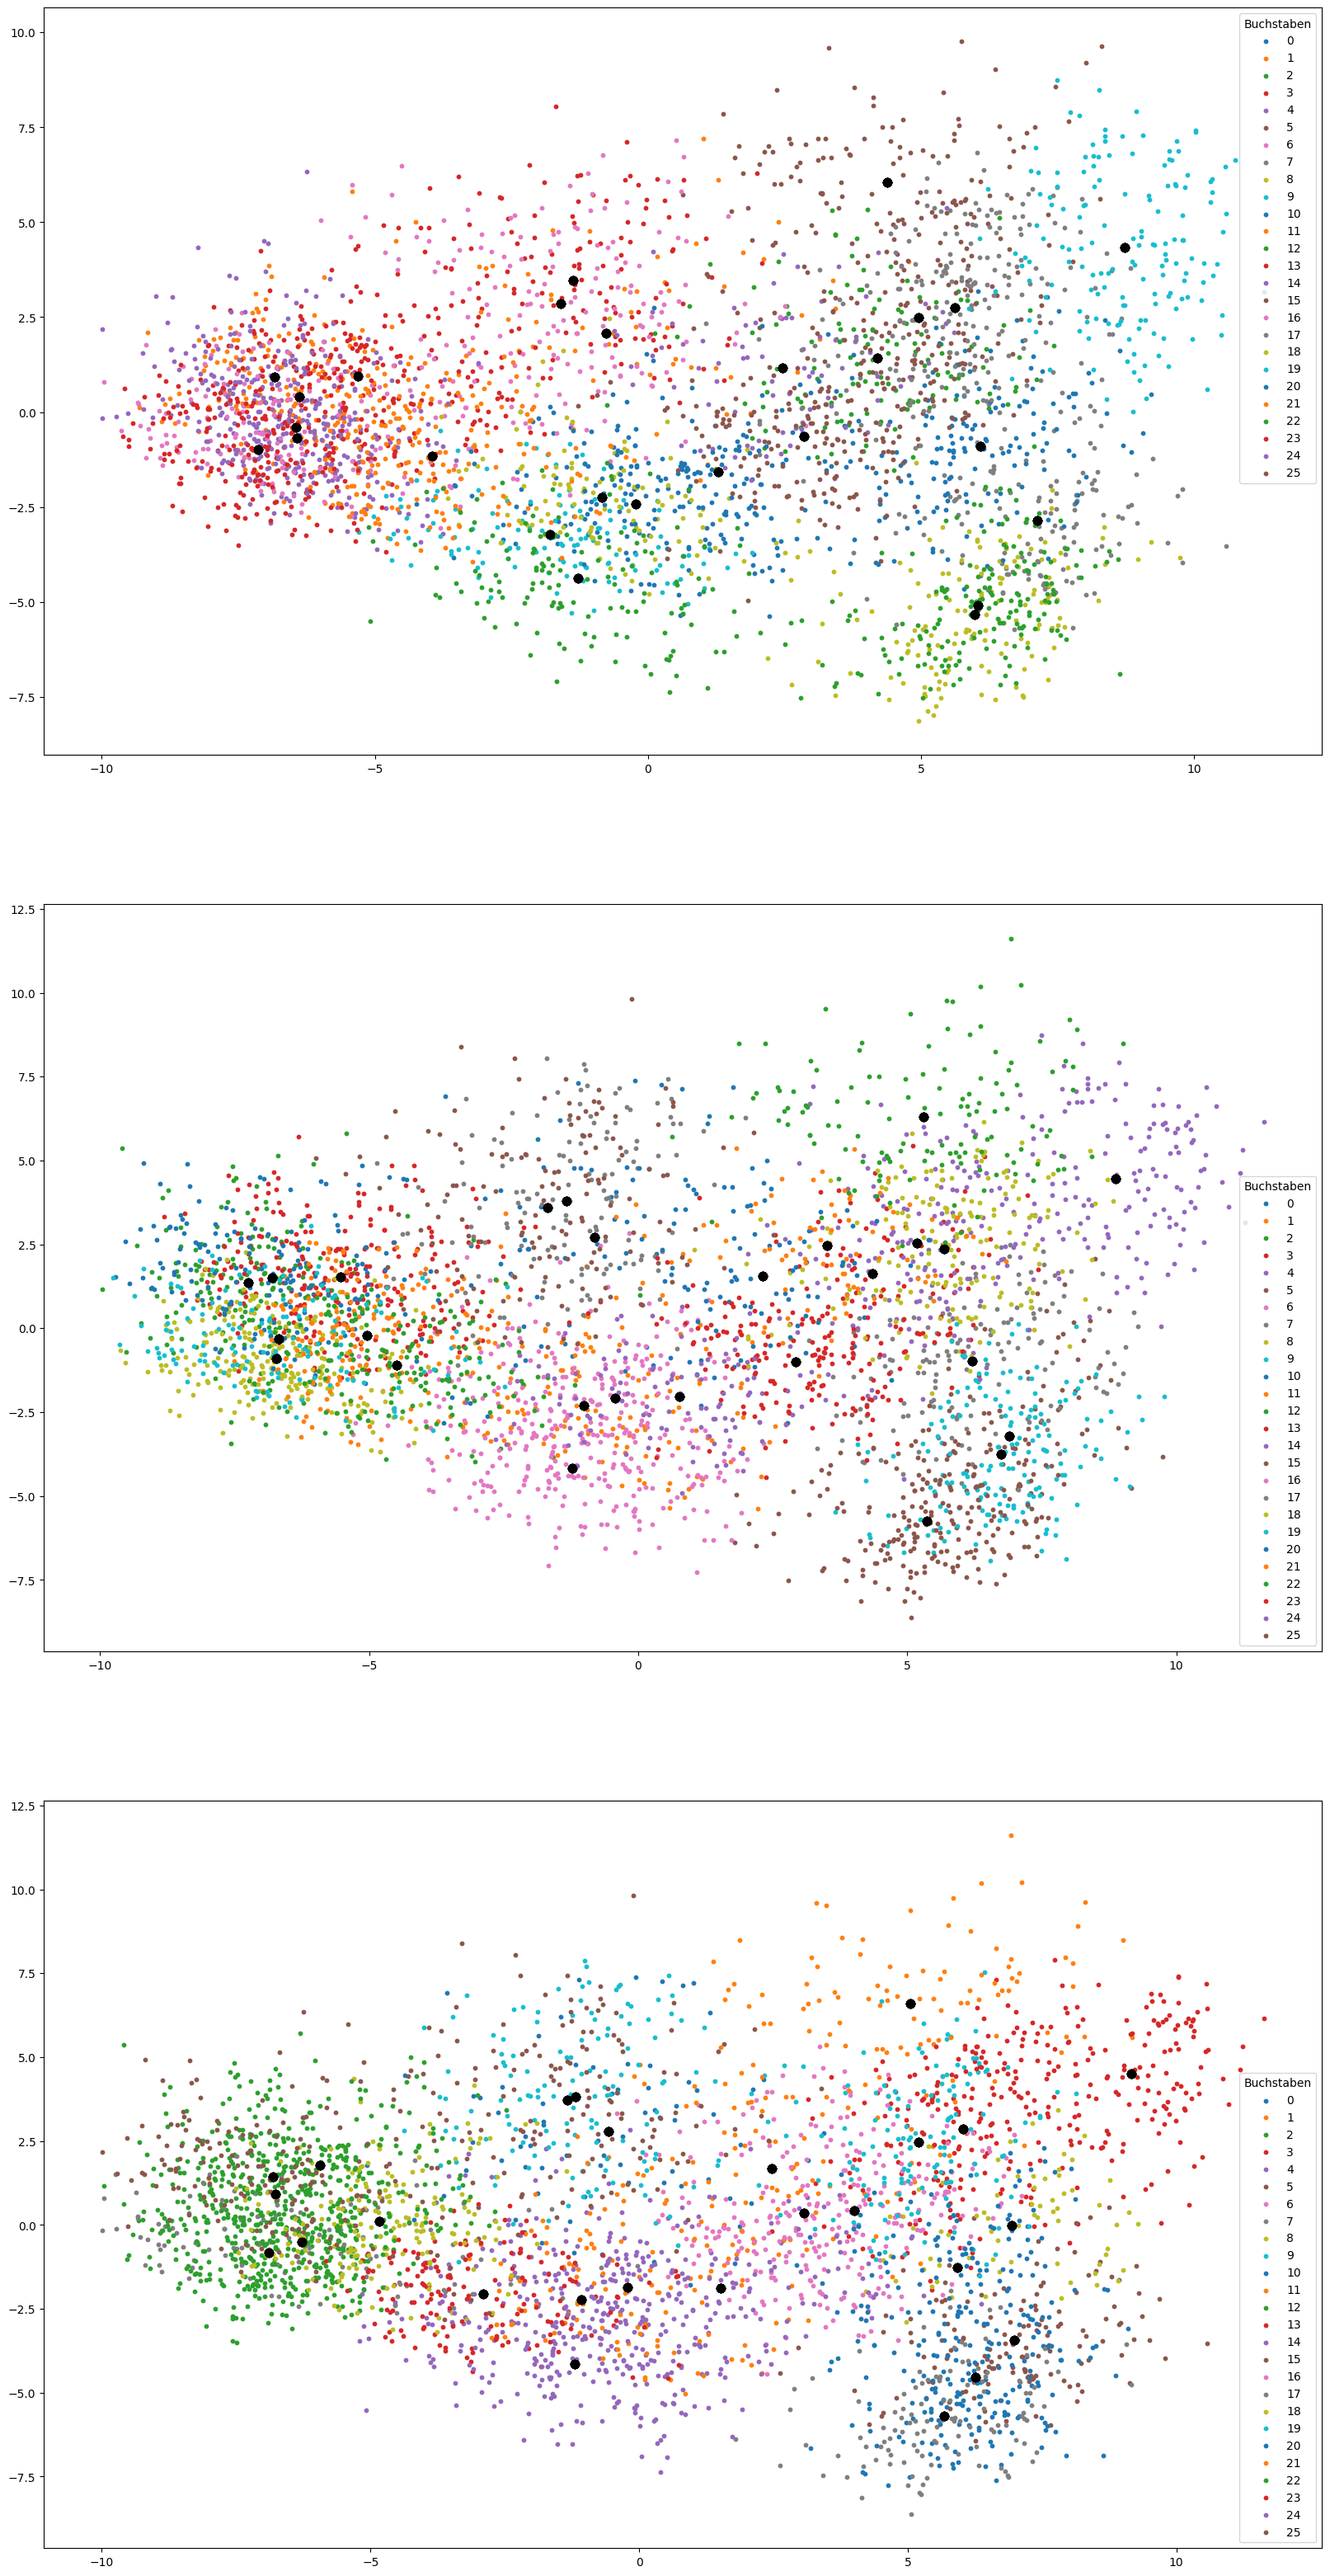

In [17]:
score = unsupervised_cross_val_score(KMeans(n_clusters=26, random_state=42), features_train_pca, letters_train, 3, True, True)
scores.append(score)

---------- Fold 1 ----------
Accuracy: 0.021549512570549
---------- Fold 2 ----------
Accuracy: 0.03796818881477681
---------- Fold 3 ----------
Accuracy: 0.025654181631605953


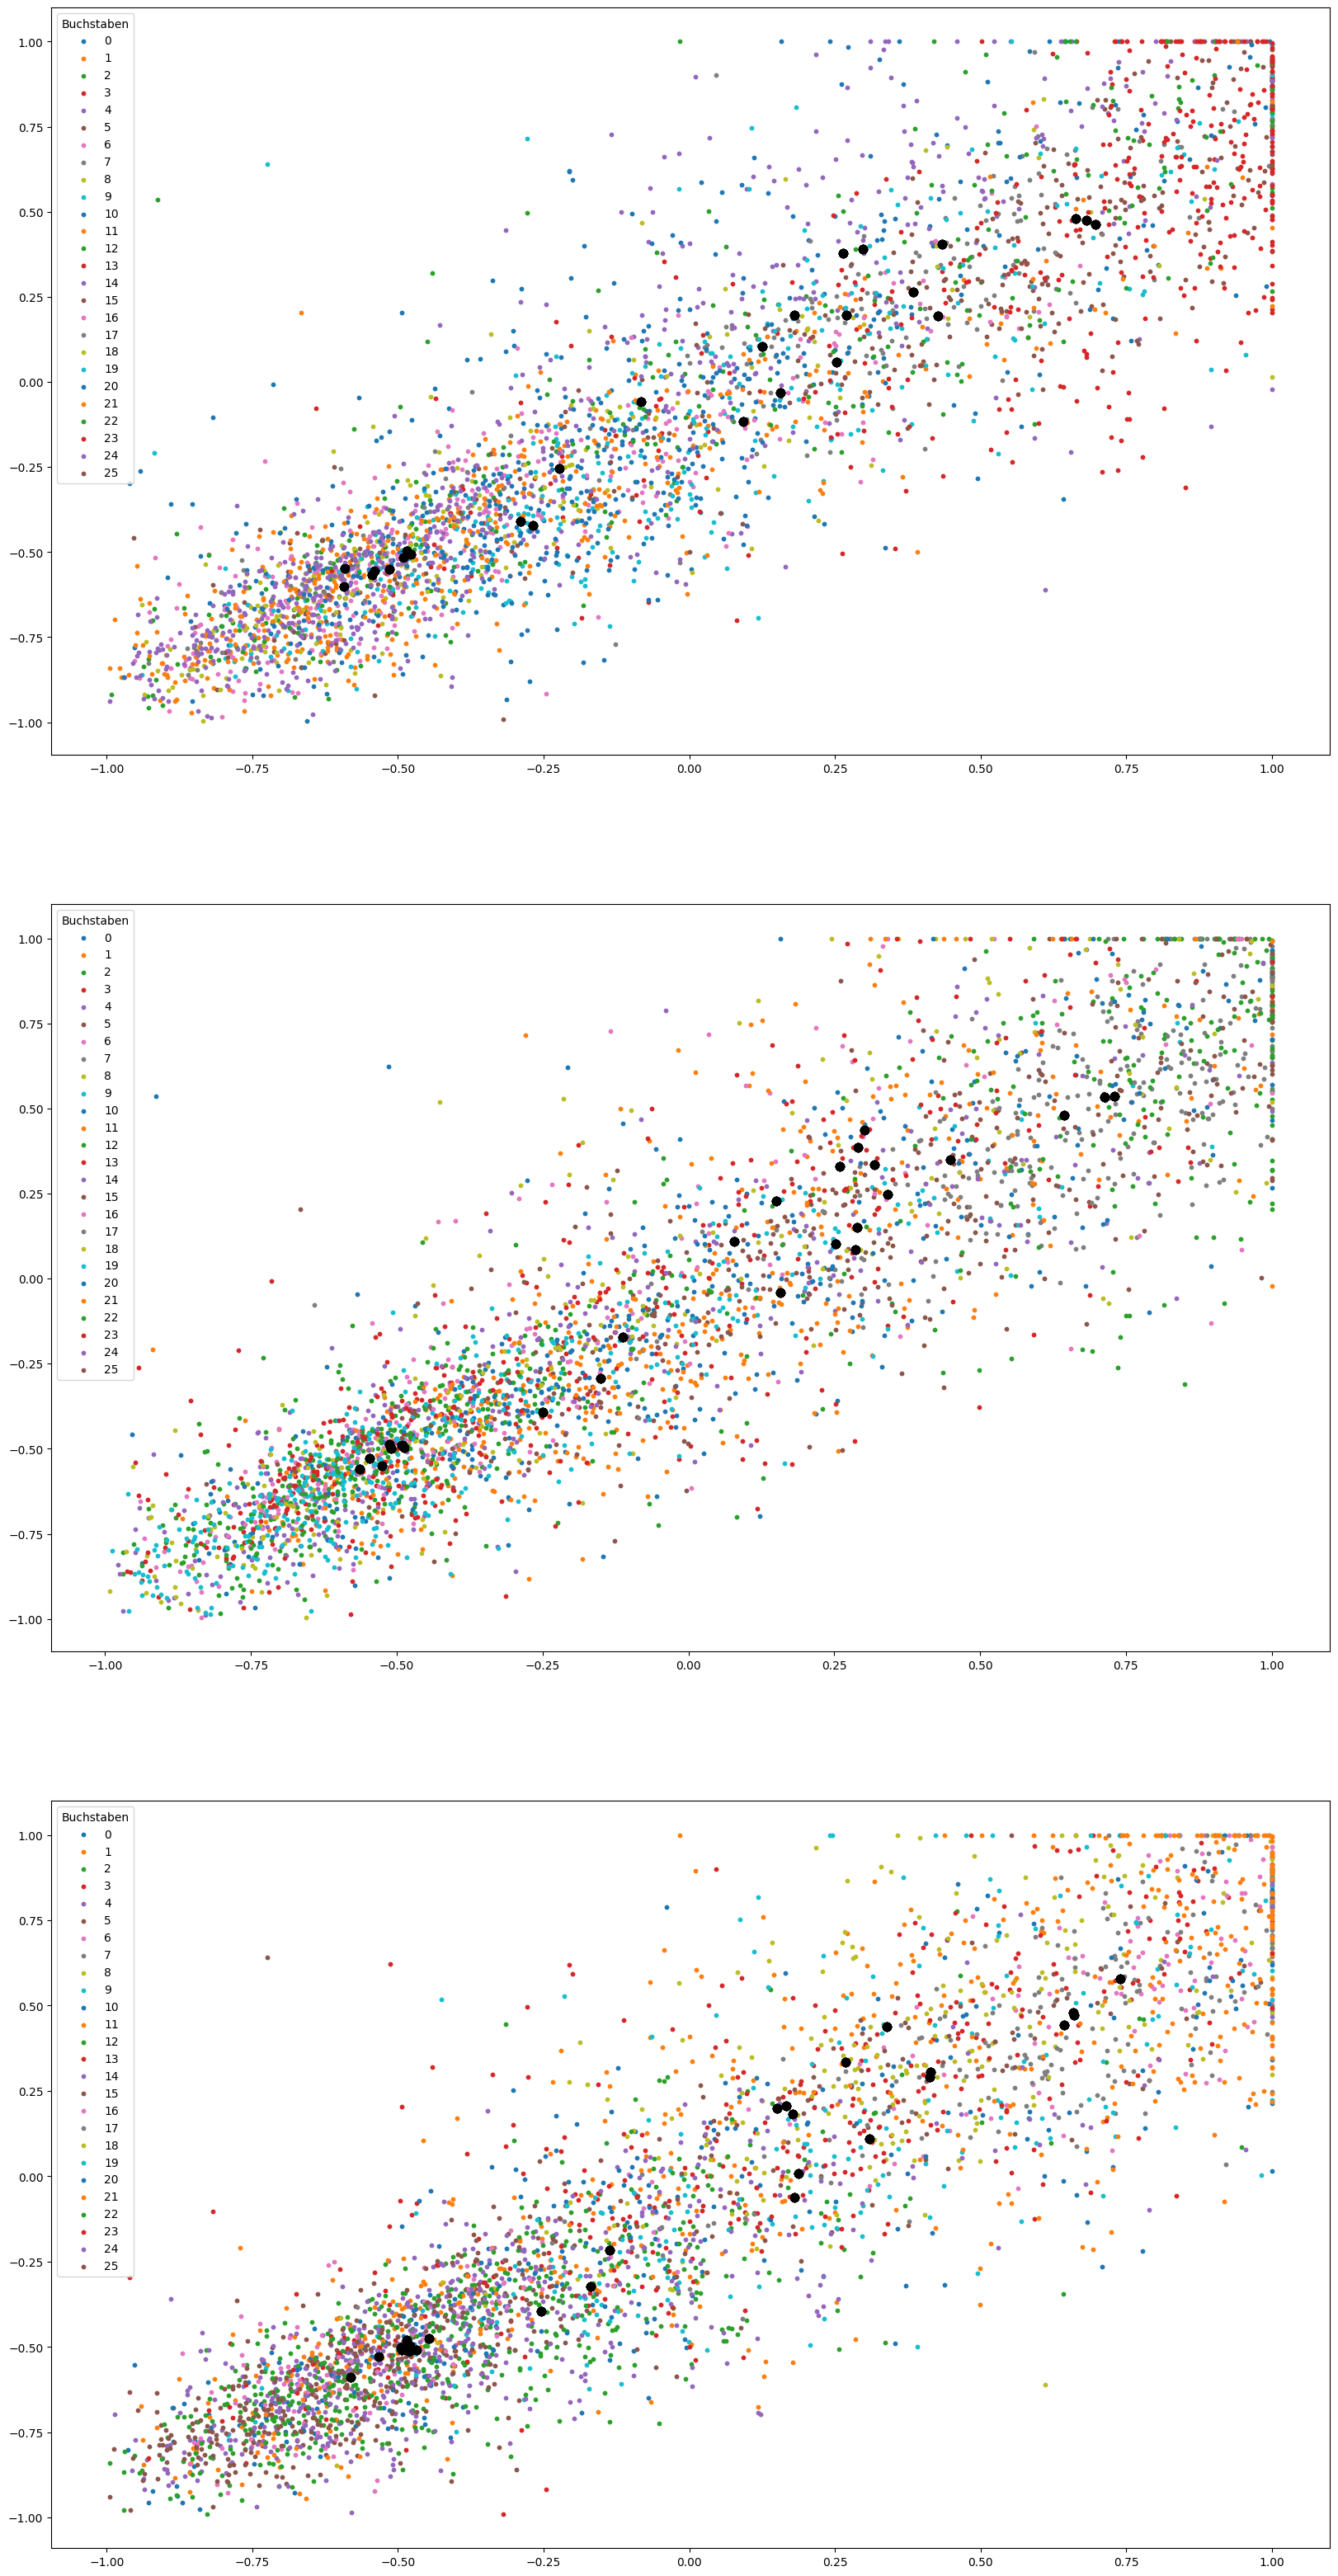

In [18]:
score = unsupervised_cross_val_score(KMeans(n_clusters=26, random_state=42), selected_features_train, letters_train, 3, True, True)
scores.append(score)

In [19]:
print(f'Accuracy mean of Random Forest with Principal Component Analysis: {np.mean(scores[0])}')
print(f'Accuracy mean of Random Forest with Fisher Score: {np.mean(scores[1])}')
print(f'Accuracy mean of k-Means Clustering with Principal Component Analysis: {np.mean(scores[2])}')
print(f'Accuracy mean of k-Means Clustering with Fisher Score: {np.mean(scores[3])}')

Accuracy mean of Random Forest with Principal Component Analysis: 0.9028561655549855
Accuracy mean of Random Forest with Fisher Score: 0.8597571404138874
Accuracy mean of k-Means Clustering with Principal Component Analysis: 0.019155122284932442
Accuracy mean of k-Means Clustering with Fisher Score: 0.028390627672310587


Die Genauigkeit beim überwachten Lernen liegt in einem sehr guten Bereich. Im Durchschnitt konnte die Merkmalsreduktions mittels PCA eine höhere Genauigkeit erzielen als mit dem Fisher Score.
Das k-Means Clustering bietet aufgrund seiner Vorgehensart einfach eine schlechte Basis zur Klassifikation dieser Aufgabe anhand der Merkmale.